## Stratified K Fold on multi-label

### Import statements

In [1]:
import fastai
print(fastai.__version__)

1.0.28


In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
import scipy.optimize as opt
from sklearn.metrics import f1_score

import math
import cv2
import subprocess
from operator import itemgetter

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
X = train_df['Id']

In [7]:
y = np.array(train_df.Target.str.split(' '))
y = [[int(k) for k in lst] for lst in y]
y[:5]

[[16, 0], [7, 1, 2, 0], [5], [1], [18]]

In [8]:
mlb = MultiLabelBinarizer()
y_onehot = mlb.fit_transform(y)
mlb.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [9]:
skf = StratifiedKFold(n_splits=5, random_state=42)

In [10]:
def convert_bits_to_number(tmp):
    count = 0
    res = 0
    for element in reversed(tmp):
        res += element * (2 ** count)
        count += 1
        
    return res

In [11]:
y_onehot_decimal = [convert_bits_to_number(t) for t in y_onehot]

In [12]:
tmp = y_onehot_decimal[1]

def convert_number_to_bits(tmp):

    binaryNum = [0] * 28; 
  
    i = 0; 
    while (tmp > 0):  
  
        binaryNum[i] = tmp % 2 
        tmp = tmp // 2
        i += 1; 
  
    return list(reversed(binaryNum))

# convert_number_to_bits(tmp)


In [13]:
train_idx = list()
test_idx = list() 
for trn, tst in skf.split(X, y_onehot_decimal):
    train_idx.append(trn)
    test_idx.append(tst)

/home/deep/fastai-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [14]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [15]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [16]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

### First Model

In [17]:
trn_idx, tst_idx = train_idx[0], test_idx[0]

In [18]:
src = (ImageItemList.from_df(train_df, path, folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [19]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [20]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [21]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [22]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [23]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [24]:
src.add_test(test_fnames, label='0');

In [25]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [26]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [27]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.,
                             xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))])

In [28]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

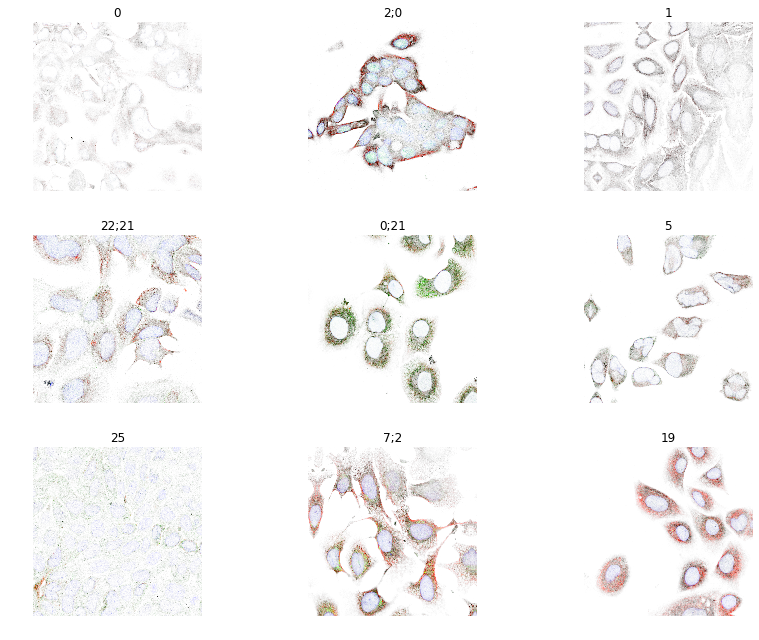

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [30]:
def resnet34(pretrained):
    return Resnet4Channel(encoder_depth=34)

In [31]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [32]:
def _resnet_split(m): return (m[0][6],m[1])

In [33]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [34]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


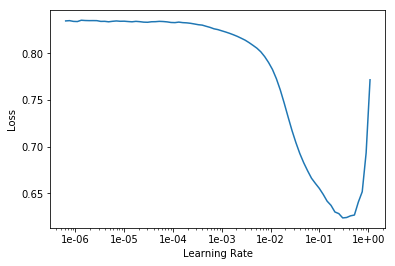

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(4, 2e-2)

Total time: 21:49
epoch  train_loss  valid_loss  fbeta   
1      0.142188    0.179361    0.415228  (05:28)
2      0.126882    0.152850    0.482475  (05:33)
3      0.114908    0.116474    0.615858  (05:27)
4      0.107792    0.107018    0.652366  (05:20)



In [37]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

Total time: 44:47
epoch  train_loss  valid_loss  fbeta   
1      0.104119    0.106160    0.656625  (05:32)
2      0.106326    0.105189    0.654645  (05:38)
3      0.104943    0.104694    0.654903  (05:31)
4      0.100841    0.103482    0.660468  (05:33)
5      0.101225    0.102201    0.667059  (05:36)
6      0.101019    0.102480    0.663614  (05:37)
7      0.099328    0.101184    0.666271  (05:37)
8      0.099293    0.101510    0.666449  (05:39)



In [38]:
learn.save("stratified-model-1-224-unfreeze")

In [35]:
_ = learn.load("stratified-model-1-224-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


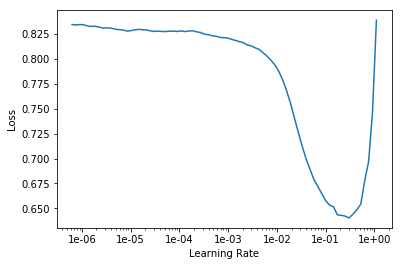

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(4, 2e-2)

Total time: 41:06
epoch  train_loss  valid_loss  fbeta   
1      0.131013    0.180707    0.406234  (10:20)
2      0.129616    0.995461    0.534422  (10:15)
3      0.110004    0.829638    0.632447  (10:14)
4      0.102490    0.853440    0.661721  (10:14)



In [37]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

Total time: 2:08:39
epoch  train_loss  valid_loss  fbeta   
1      0.100703    0.730491    0.669467  (12:55)
2      0.102411    0.456980    0.674286  (12:52)
3      0.098729    0.284942    0.677449  (12:52)
4      0.100746    0.420418    0.675710  (12:48)
5      0.097551    0.215026    0.686922  (12:48)
6      0.098107    0.218470    0.687642  (12:51)
7      0.094817    0.158919    0.692296  (12:51)
8      0.095605    0.160605    0.693696  (12:53)
9      0.094380    0.330931    0.692816  (12:52)
10     0.093078    0.176585    0.692853  (12:52)



In [40]:
learn.fit_one_cycle(10, slice(1e-8, 5e-6))

Total time: 2:08:40
epoch  train_loss  valid_loss  fbeta   
1      0.094815    0.157733    0.692828  (12:52)
2      0.092239    0.170997    0.693925  (12:52)
3      0.096253    0.168785    0.691411  (12:51)
4      0.094864    0.118398    0.695301  (12:52)
5      0.095298    0.186609    0.692568  (12:52)
6      0.094316    0.221345    0.694200  (12:52)
7      0.095038    0.198074    0.695435  (12:51)
8      0.094674    0.229477    0.688729  (12:52)
9      0.094883    0.207209    0.695395  (12:50)
10     0.092720    0.140153    0.697836  (12:52)



In [41]:
learn.save("stratified-model-1-386-unfreeze")

In [35]:
_ = learn.load("stratified-model-1-386-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


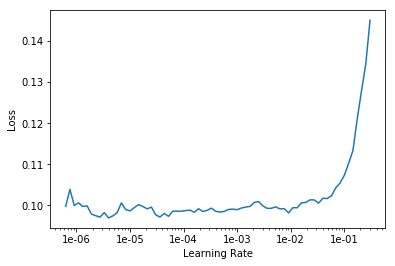

In [36]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, 2e-2)

Total time: 1:31:27
epoch  train_loss  valid_loss  fbeta   
1      0.118271    1.513791    0.594742  (15:17)
2      0.145472    2.994881    0.481228  (15:14)
3      0.139812    0.721762    0.453152  (15:15)
4      0.122511    5.825443    0.521910  (15:14)
5      0.112592    2.239539    0.614606  (15:12)
6      0.105907    2.405339    0.622036  (15:12)



In [ ]:
learn.unfreeze()
learn.fit_one_cycle(14, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,fbeta
1,0.108207,3.128180,0.628408
2,0.106647,3.035254,0.632921
3,0.106592,4.196410,0.620923
4,0.107593,2.898976,0.636831
5,0.102391,2.971687,0.639670
6,0.099526,2.714013,0.656397
7,0.097670,1.916624,0.638384
8,0.099850,1.410401,0.655924
9,0.098355,1.162195,0.653878
10,0.099438,1.092366,0.660511


In [ ]:
learn.save("stratified-model-1-512-unfreeze")

In [35]:
_ = learn.load("stratified-model-1-512-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


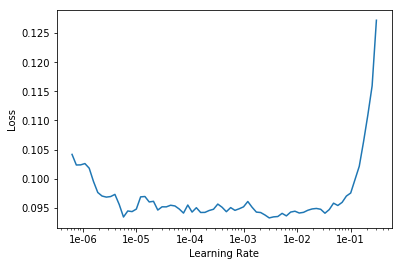

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(14, slice(1e-8, 5e-6))

Total time: 3:33:53
epoch  train_loss  valid_loss  fbeta   
1      0.096580    1.494947    0.659137  (15:24)
2      0.097534    2.056405    0.653511  (15:17)
3      0.096670    1.644279    0.657855  (15:20)
4      0.094703    1.670094    0.666273  (15:17)
5      0.099917    2.153265    0.662908  (15:20)
6      0.094926    1.810708    0.664929  (15:18)
7      0.095230    2.360484    0.660369  (15:15)
8      0.097750    2.665416    0.664763  (15:15)
9      0.096844    2.410453    0.660743  (15:14)
10     0.099761    1.105992    0.665067  (15:13)
11     0.097906    2.683320    0.655431  (15:13)
12     0.094248    1.248378    0.668241  (15:13)
13     0.095882    3.768642    0.657118  (15:13)
14     0.094576    1.644131    0.666514  (15:13)



In [38]:
learn.save("stratified-model-1-512-unfreeze")

### Second Model 

In [17]:
trn_idx, tst_idx = train_idx[1], test_idx[1]

In [18]:
src = (ImageItemList.from_df(train_df, path, folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [19]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [20]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [21]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [22]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [23]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [24]:
src.add_test(test_fnames, label='0');

In [25]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [26]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [27]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.,
                             xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))])

In [28]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


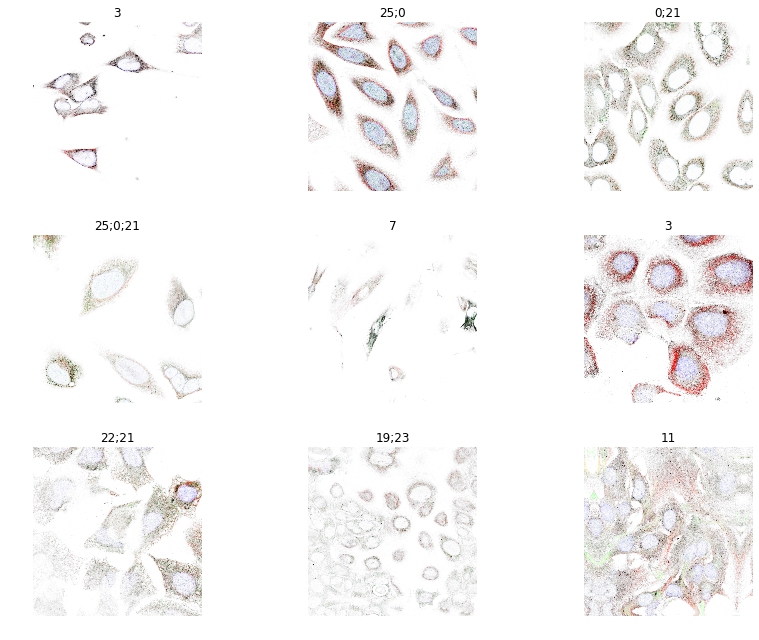

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [30]:
def resnet34(pretrained):
    return Resnet4Channel(encoder_depth=34)

In [31]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [32]:
def _resnet_split(m): return (m[0][6],m[1])

In [33]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [34]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


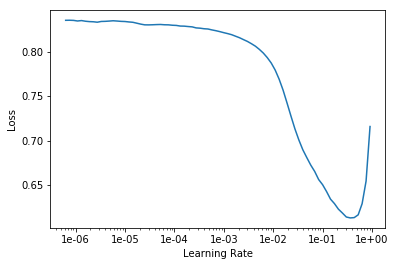

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(4, 2e-2)

Total time: 22:21
epoch  train_loss  valid_loss  fbeta   
1      0.140995    0.180976    0.435329  (05:35)
2      0.127425    0.134987    0.534667  (05:38)
3      0.116344    0.116763    0.595802  (05:36)
4      0.106728    0.103985    0.647703  (05:31)



In [37]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

Total time: 45:23
epoch  train_loss  valid_loss  fbeta   
1      0.103531    0.104932    0.648367  (05:44)
2      0.102931    0.102205    0.655173  (05:40)
3      0.102554    0.104494    0.655978  (05:39)
4      0.101238    0.100514    0.660018  (05:41)
5      0.099546    0.099731    0.663334  (05:40)
6      0.099563    0.099824    0.665970  (05:40)
7      0.098335    0.098849    0.666052  (05:38)
8      0.098957    0.098762    0.666903  (05:38)



In [38]:
learn.save("stratified-model-2-224-unfreeze")

In [35]:
_ = learn.load("stratified-model-2-224-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


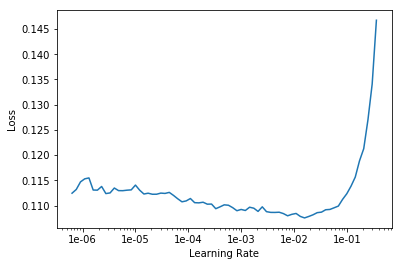

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(4, 2e-2)

Total time: 41:51
epoch  train_loss  valid_loss  fbeta   
1      0.123309    0.145605    0.468867  (10:35)
2      0.127479    0.227625    0.562461  (10:31)
3      0.109960    0.257757    0.641163  (10:25)
4      0.101754    0.309978    0.676433  (10:18)



In [38]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

Total time: 2:09:45
epoch  train_loss  valid_loss  fbeta   
1      0.097977    0.490387    0.681825  (12:59)
2      0.095326    0.222853    0.683008  (12:58)
3      0.096816    0.223285    0.688787  (12:55)
4      0.097866    0.244062    0.686593  (13:03)
5      0.095563    0.159596    0.692531  (12:58)
6      0.092059    0.510972    0.694651  (12:56)
7      0.093720    0.218149    0.699657  (12:56)
8      0.091366    0.188942    0.699386  (12:55)
9      0.091079    0.169126    0.702513  (13:01)
10     0.092205    0.292085    0.700609  (13:00)



In [39]:
learn.fit_one_cycle(10, slice(1e-8, 5e-6))

Total time: 2:09:57
epoch  train_loss  valid_loss  fbeta   
1      0.090473    0.170845    0.701463  (12:59)
2      0.093100    0.202978    0.702395  (13:00)
3      0.091708    0.198302    0.700462  (12:59)
4      0.092546    0.195404    0.702810  (13:00)
5      0.092462    0.237037    0.700588  (13:01)
6      0.092946    0.210343    0.703040  (13:01)
7      0.093189    0.188722    0.704058  (13:02)
8      0.088809    0.141642    0.699161  (13:00)
9      0.093642    0.220966    0.703010  (12:56)
10     0.092285    0.167142    0.701698  (12:54)



In [40]:
learn.save("stratified-model-2-386-unfreeze")

In [35]:
_ = learn.load("stratified-model-2-386-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


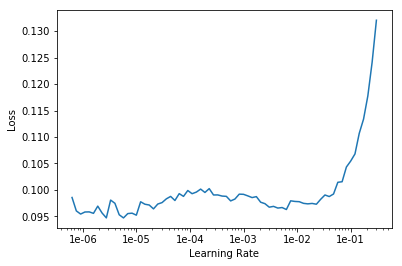

In [36]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, 2e-3)

epoch,train_loss,valid_loss,fbeta
1,0.097592,0.608096,0.669071
2,0.096474,0.377495,0.670379
3,0.098228,0.374960,0.664718
4,0.091090,0.322890,0.666489


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.unfreeze()
learn.fit_one_cycle(14, slice(1e-6, 1e-4))

In [ ]:
learn.save("stratified-model-2-512-unfreeze")

In [41]:
_ = learn.load("stratified-model-2-512-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


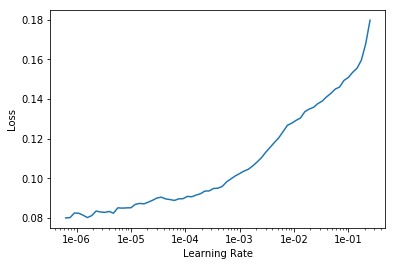

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(14, slice(1e-8, 5e-6))

Total time: 4:27:18
epoch  train_loss  valid_loss  fbeta   
1      0.086797    0.687188    0.701185  (19:03)
2      0.086233    0.245863    0.707507  (19:01)
3      0.083336    0.226489    0.699052  (19:02)
4      0.082440    0.155053    0.701278  (19:01)
5      0.084106    0.846807    0.692287  (19:01)
6      0.082153    0.188075    0.695657  (19:02)
7      0.082698    0.452341    0.696570  (19:05)
8      0.082210    0.296779    0.704605  (19:09)
9      0.087201    0.428871    0.698768  (19:11)
10     0.084476    0.289681    0.698429  (19:10)
11     0.086406    0.310059    0.696021  (19:14)
12     0.083009    0.282045    0.697383  (19:11)
13     0.083445    0.264086    0.699040  (19:02)
14     0.082720    0.428437    0.699611  (19:02)



In [44]:
learn.save("stratified-model-2-512-unfreeze")

### Third Model 

In [17]:
trn_idx, tst_idx = train_idx[2], test_idx[2]

In [18]:
src = (ImageItemList.from_df(train_df, path, folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [19]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [20]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [21]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [22]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [23]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [24]:
src.add_test(test_fnames, label='0');

In [25]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [26]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [27]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.,
                             xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))])

In [28]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

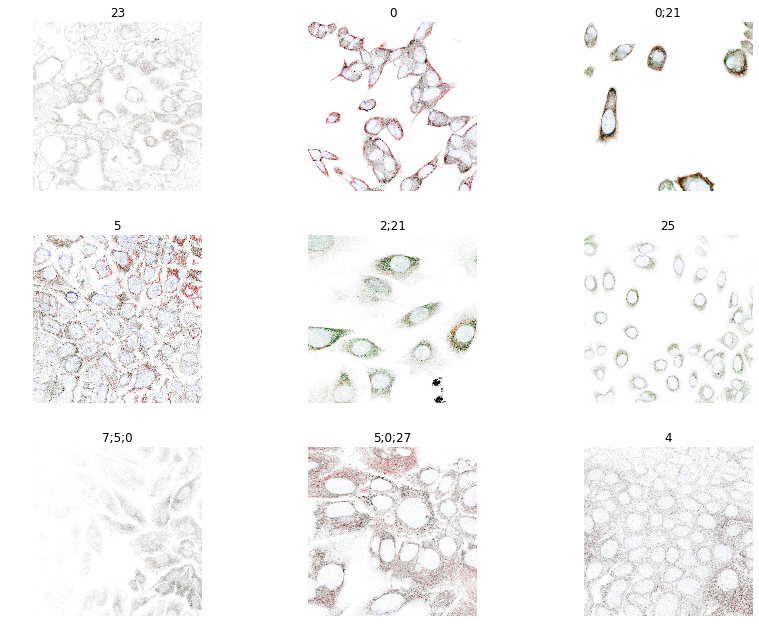

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [30]:
def resnet34(pretrained):
    return Resnet4Channel(encoder_depth=34)

In [31]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [32]:
def _resnet_split(m): return (m[0][6],m[1])

In [33]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [34]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


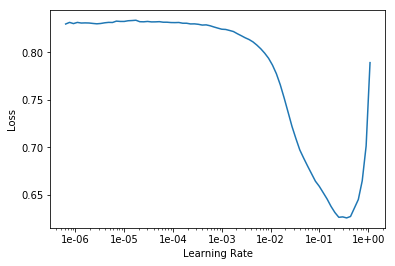

In [35]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(4, 2e-2)

Total time: 19:53
epoch  train_loss  valid_loss  fbeta   
1      0.138682    0.148088    0.467451  (05:12)
2      0.131536    0.136120    0.487626  (05:02)
3      0.122231    0.113902    0.594599  (04:51)
4      0.110668    0.103872    0.637378  (04:47)



In [36]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

Total time: 40:46
epoch  train_loss  valid_loss  fbeta   
1      0.108876    0.103345    0.638505  (05:01)
2      0.108322    0.102659    0.640929  (05:02)
3      0.105333    0.101785    0.642426  (05:03)
4      0.105478    0.100984    0.646736  (05:07)
5      0.104512    0.099916    0.650541  (05:07)
6      0.103725    0.099156    0.652230  (05:08)
7      0.103701    0.099093    0.652148  (05:08)
8      0.104141    0.098957    0.650696  (05:07)



In [37]:
learn.save("stratified-model-3-224-unfreeze")

In [35]:
_ = learn.load("stratified-model-3-224-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


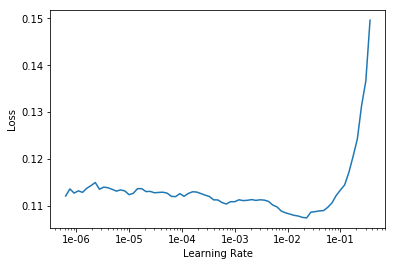

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(4, 1e-2)

Total time: 38:21
epoch  train_loss  valid_loss  fbeta   
1      0.111381    0.132898    0.554005  (09:37)
2      0.112317    0.127152    0.635799  (09:34)
3      0.101875    0.377158    0.679605  (09:34)
4      0.096904    0.118871    0.691020  (09:34)



In [38]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

Total time: 2:03:40
epoch  train_loss  valid_loss  fbeta   
1      0.096380    0.115775    0.696017  (12:24)
2      0.094258    0.120422    0.696578  (12:20)
3      0.094300    0.126907    0.697731  (12:21)
4      0.094545    0.181947    0.696813  (12:22)
5      0.091664    0.098026    0.708028  (12:20)
6      0.093166    0.229344    0.708165  (12:22)
7      0.089663    0.167267    0.705724  (12:21)
8      0.089470    0.090866    0.711692  (12:20)
9      0.086831    0.093023    0.713006  (12:21)
10     0.088267    0.087601    0.712939  (12:23)



In [39]:
learn.fit_one_cycle(10, slice(1e-8, 5e-6))

Total time: 2:03:39
epoch  train_loss  valid_loss  fbeta   
1      0.087742    0.083994    0.712811  (12:21)
2      0.086724    0.086835    0.714699  (12:22)
3      0.087889    0.088958    0.711180  (12:21)
4      0.088609    0.112967    0.714494  (12:22)
5      0.087325    0.140256    0.713052  (12:21)
6      0.086783    0.084081    0.714341  (12:21)
7      0.085670    0.119051    0.717868  (12:22)
8      0.087980    0.087098    0.714494  (12:21)
9      0.087535    0.088936    0.714640  (12:21)
10     0.088407    0.091017    0.713772  (12:22)



In [40]:
learn.save("stratified-model-3-386-unfreeze")

In [35]:
_ = learn.load("stratified-model-3-386-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


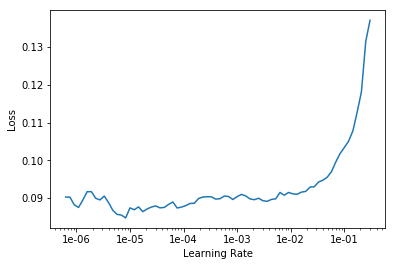

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(6, 2e-3)

Total time: 1:26:58
epoch  train_loss  valid_loss  fbeta   
1      0.093975    1.219419    0.684426  (14:33)
2      0.091469    0.198137    0.664783  (14:24)
3      0.094783    0.345273    0.689994  (14:29)
4      0.092256    0.157907    0.704703  (14:30)
5      0.089233    0.123105    0.711463  (14:29)
6      0.084376    0.139732    0.711965  (14:30)



In [38]:
learn.unfreeze()
learn.fit_one_cycle(14, slice(1e-6, 1e-4))

Total time: 4:26:38
epoch  train_loss  valid_loss  fbeta   
1      0.087781    0.090246    0.712475  (19:04)
2      0.086239    0.102704    0.705639  (19:00)
3      0.088062    0.105878    0.708194  (19:00)
4      0.089917    0.120335    0.696846  (19:00)
5      0.090345    0.133741    0.698718  (19:02)
6      0.087367    0.104208    0.714535  (19:02)
7      0.084217    0.094315    0.714413  (19:02)
8      0.087279    0.175638    0.713785  (19:02)
9      0.083532    0.105069    0.711743  (19:02)
10     0.082026    0.104130    0.717914  (19:03)
11     0.084604    0.117944    0.721979  (19:03)
12     0.083189    0.092243    0.727707  (19:04)
13     0.081923    0.092017    0.723082  (19:04)
14     0.080402    0.124176    0.721707  (19:03)



In [39]:
learn.save("stratified-model-3-512-unfreeze")

In [40]:
_ = learn.load("stratified-model-3-512-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


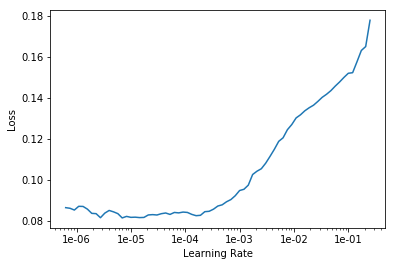

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(14, slice(1e-8, 5e-6))

Total time: 4:27:19
epoch  train_loss  valid_loss  fbeta   
1      0.081899    0.127749    0.723836  (19:03)
2      0.078806    0.110346    0.712038  (19:01)
3      0.081121    0.145046    0.724767  (19:02)
4      0.081620    0.121208    0.725629  (19:01)
5      0.080754    0.093899    0.722833  (19:03)
6      0.079875    0.114042    0.723961  (19:11)
7      0.083698    0.092677    0.725565  (19:06)
8      0.082070    0.090218    0.724245  (19:05)
9      0.078600    0.096187    0.723546  (19:04)
10     0.077916    0.097544    0.717406  (19:06)
11     0.079554    0.102271    0.721721  (19:07)
12     0.082851    0.094435    0.719973  (19:06)
13     0.081921    0.093728    0.724653  (19:09)
14     0.085460    0.097053    0.721611  (19:08)



In [43]:
learn.save("stratified-model-3-512-unfreeze")

### Fourth Model 

In [17]:
trn_idx, tst_idx = train_idx[3], test_idx[3]

In [18]:
src = (ImageItemList.from_df(train_df, path, folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [19]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [20]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [21]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [22]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [23]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [24]:
src.add_test(test_fnames, label='0');

In [25]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [26]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [27]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.,
                             xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))])

In [28]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

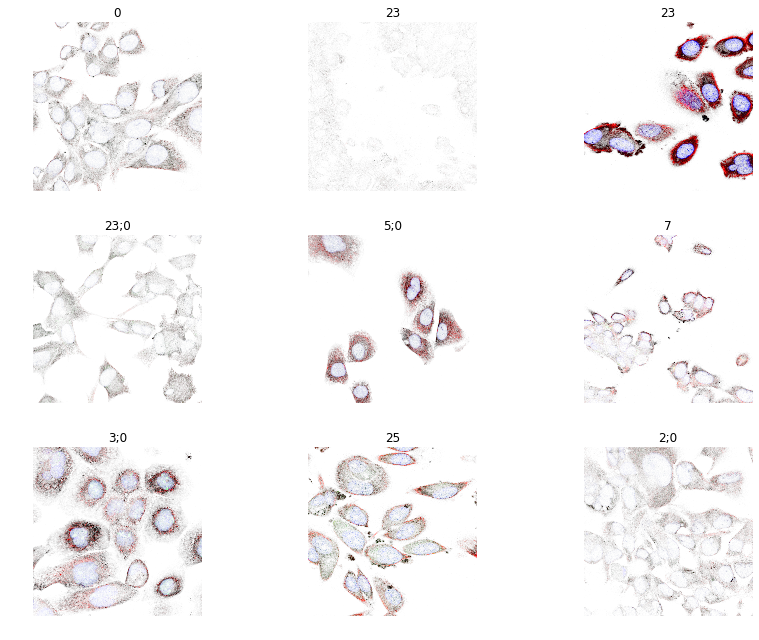

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [30]:
def resnet34(pretrained):
    return Resnet4Channel(encoder_depth=34)

In [31]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [32]:
def _resnet_split(m): return (m[0][6],m[1])

In [33]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [34]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


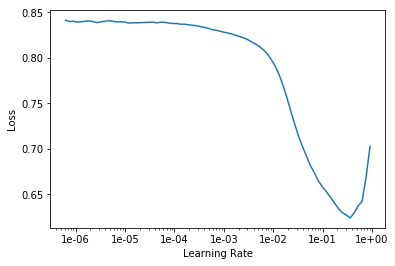

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(4, 2e-2)

Total time: 40:49
epoch  train_loss  valid_loss  fbeta   
1      0.138013    0.152965    0.429340  (10:26)
2      0.133623    0.144348    0.486695  (10:21)
3      0.118563    0.110117    0.617899  (10:02)
4      0.107883    0.100114    0.651373  (09:59)



In [37]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

Total time: 56:51
epoch  train_loss  valid_loss  fbeta   
1      0.108514    0.099342    0.654629  (10:03)
2      0.106699    0.098709    0.656227  (10:05)
3      0.106424    0.098287    0.656190  (09:57)
4      0.104511    0.097544    0.657019  (05:22)
5      0.104305    0.096417    0.664730  (05:20)
6      0.102793    0.095752    0.668090  (05:21)
7      0.102674    0.095597    0.667740  (05:20)
8      0.101467    0.095474    0.669387  (05:19)



In [38]:
learn.save("stratified-model-4-224-unfreeze")

In [35]:
_ = learn.load("stratified-model-4-224-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


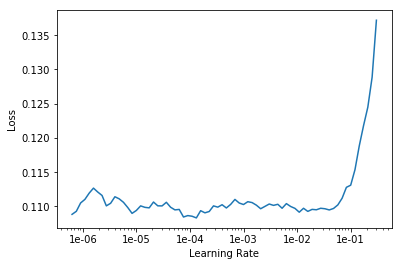

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(4, 2e-3)

Total time: 38:37
epoch  train_loss  valid_loss  fbeta   
1      0.099993    0.089387    0.686529  (09:42)
2      0.095219    0.088270    0.707391  (09:40)
3      0.091977    0.083940    0.712206  (09:40)
4      0.091045    0.083221    0.718908  (09:33)



In [38]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

Total time: 2:04:20
epoch  train_loss  valid_loss  fbeta   
1      0.094241    0.083581    0.715964  (12:24)
2      0.089227    0.083134    0.714719  (12:31)
3      0.090474    0.084047    0.718960  (12:28)
4      0.089872    0.082845    0.714626  (12:26)
5      0.090736    0.081839    0.717451  (12:25)
6      0.085948    0.081209    0.726411  (12:24)
7      0.085106    0.080068    0.729949  (12:25)
8      0.084671    0.079174    0.727917  (12:24)
9      0.082671    0.079761    0.729143  (12:26)
10     0.083349    0.079354    0.733300  (12:24)



In [40]:
learn.fit_one_cycle(10, slice(1e-8, 5e-6))

Total time: 2:04:21
epoch  train_loss  valid_loss  fbeta   
1      0.085378    0.079180    0.730529  (12:24)
2      0.087101    0.079177    0.730519  (12:25)
3      0.085419    0.079220    0.733884  (12:25)
4      0.084169    0.079005    0.731685  (12:27)
5      0.085722    0.079493    0.732331  (12:28)
6      0.088037    0.079551    0.732785  (12:26)
7      0.084626    0.079208    0.730244  (12:25)
8      0.083709    0.078971    0.727506  (12:26)
9      0.085344    0.079431    0.729181  (12:27)
10     0.086078    0.078997    0.732222  (12:25)



In [41]:
learn.save("stratified-model-4-386-unfreeze")

In [35]:
_ = learn.load("stratified-model-4-386-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


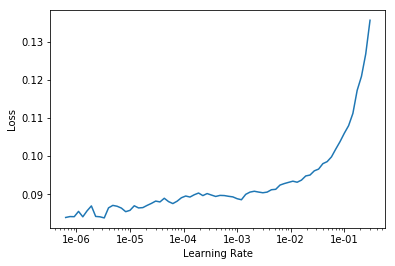

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(6, 2e-3)

Total time: 1:28:16
epoch  train_loss  valid_loss  fbeta   
1      0.093912    0.090439    0.695152  (14:47)
2      0.092547    0.095129    0.686784  (14:41)
3      0.092823    0.086902    0.702710  (14:41)
4      0.089739    0.085318    0.707239  (14:42)
5      0.090476    0.082824    0.721972  (14:41)
6      0.090063    0.082268    0.724041  (14:41)



In [38]:
learn.unfreeze()
learn.fit_one_cycle(14, slice(1e-6, 1e-4))

Total time: 4:28:38
epoch  train_loss  valid_loss  fbeta   
1      0.085330    0.083219    0.715766  (19:13)
2      0.090028    0.083447    0.718280  (19:09)
3      0.088213    0.086776    0.703974  (19:09)
4      0.088752    0.082898    0.717666  (19:08)
5      0.088033    0.082711    0.721701  (19:10)
6      0.085407    0.087122    0.708841  (19:11)
7      0.083799    0.081021    0.721111  (19:10)
8      0.080352    0.080520    0.723471  (19:11)
9      0.084518    0.082573    0.724082  (19:12)
10     0.079789    0.080779    0.726371  (19:12)
11     0.079456    0.079534    0.731608  (19:11)
12     0.076822    0.078564    0.732918  (19:10)
13     0.077405    0.077842    0.731339  (19:12)
14     0.078843    0.079237    0.734506  (19:12)



In [39]:
learn.save("stratified-model-4-512-unfreeze")

In [40]:
_ = learn.load("stratified-model-4-512-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


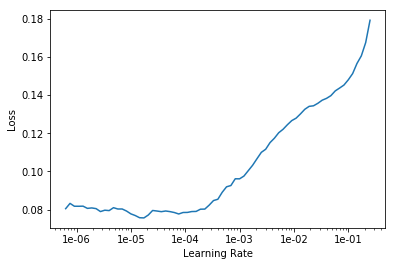

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(14, slice(1e-8, 5e-6))

Total time: 4:28:39
epoch  train_loss  valid_loss  fbeta   
1      0.079177    0.078545    0.733692  (19:10)
2      0.078337    0.078465    0.730061  (19:10)
3      0.077813    0.079172    0.735303  (19:10)
4      0.077473    0.078564    0.732922  (19:09)
5      0.079572    0.078774    0.726494  (19:11)
6      0.075823    0.078081    0.728704  (19:11)
7      0.078758    0.078997    0.734244  (19:10)
8      0.075417    0.079073    0.727498  (19:10)
9      0.081355    0.078790    0.731695  (19:10)
10     0.080916    0.079095    0.734211  (19:11)
11     0.073129    0.078444    0.731693  (19:12)
12     0.073507    0.079861    0.732480  (19:12)
13     0.078057    0.079602    0.729650  (19:12)
14     0.082061    0.078600    0.736192  (19:12)



In [43]:
learn.save("stratified-model-4-512-unfreeze")

### Fifth Model

In [17]:
trn_idx, tst_idx = train_idx[4], test_idx[4]

In [18]:
src = (ImageItemList.from_df(train_df, path, folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [19]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [20]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [21]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [22]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [23]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [24]:
src.add_test(test_fnames, label='0');

In [25]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [26]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [27]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.,
                             xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))])

In [28]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

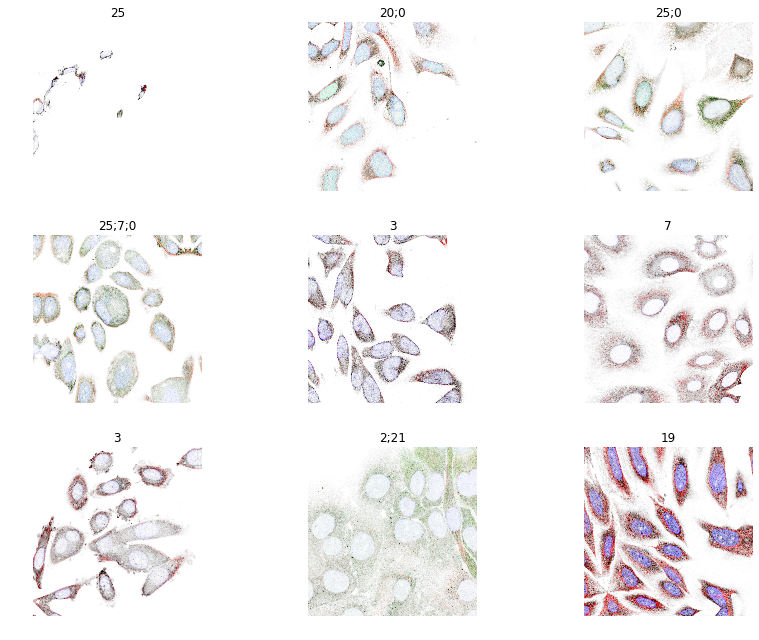

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [30]:
def resnet34(pretrained):
    return Resnet4Channel(encoder_depth=34)

In [31]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [32]:
def _resnet_split(m): return (m[0][6],m[1])

In [33]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [34]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


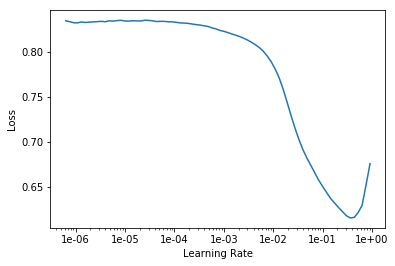

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(4, 2e-2)

Total time: 19:46
epoch  train_loss  valid_loss  fbeta   
1      0.141102    0.149238    0.439549  (05:00)
2      0.127345    0.149543    0.478823  (05:00)
3      0.114925    0.106091    0.613488  (04:56)
4      0.107795    0.095803    0.656023  (04:48)



In [37]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

Total time: 40:43
epoch  train_loss  valid_loss  fbeta   
1      0.106312    0.095207    0.661516  (05:04)
2      0.104648    0.094440    0.664137  (05:05)
3      0.104549    0.093856    0.665646  (05:02)
4      0.102803    0.092826    0.670494  (05:01)
5      0.101060    0.092016    0.673797  (05:06)
6      0.099023    0.091706    0.676879  (05:05)
7      0.100702    0.091196    0.679080  (05:08)
8      0.099049    0.091574    0.677929  (05:08)



In [38]:
learn.save("stratified-model-5-224-unfreeze")

In [35]:
_ = learn.load("stratified-model-5-224-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


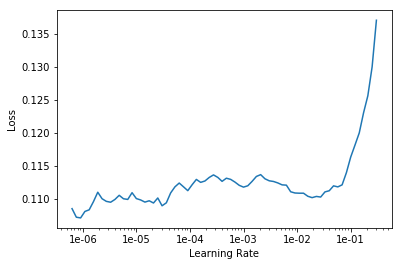

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(4, 2e-3)

Total time: 38:38
epoch  train_loss  valid_loss  fbeta   
1      0.098148    0.084410    0.706801  (09:41)
2      0.098197    0.082510    0.707818  (09:39)
3      0.090958    0.079136    0.724861  (09:38)
4      0.088077    0.077978    0.723193  (09:38)



In [38]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

Total time: 2:05:04
epoch  train_loss  valid_loss  fbeta   
1      0.090884    0.078119    0.723413  (12:31)
2      0.088536    0.078070    0.724678  (12:30)
3      0.088760    0.078536    0.723321  (12:29)
4      0.089428    0.077400    0.730450  (12:29)
5      0.085121    0.076345    0.731602  (12:29)
6      0.086070    0.075183    0.737300  (12:30)
7      0.084542    0.074408    0.739819  (12:30)
8      0.083169    0.073935    0.742053  (12:30)
9      0.082481    0.073886    0.742095  (12:31)
10     0.081163    0.073683    0.743801  (12:31)



In [39]:
learn.fit_one_cycle(10, slice(1e-8, 5e-6))

Total time: 2:05:01
epoch  train_loss  valid_loss  fbeta   
1      0.083178    0.073644    0.741231  (12:29)
2      0.081990    0.073691    0.743079  (12:30)
3      0.080009    0.073745    0.744949  (12:29)
4      0.082026    0.073721    0.741872  (12:31)
5      0.079672    0.073802    0.737696  (12:31)
6      0.081493    0.073624    0.742083  (12:29)
7      0.080281    0.073727    0.743398  (12:30)
8      0.083718    0.073970    0.744205  (12:29)
9      0.081615    0.073839    0.744790  (12:29)
10     0.081935    0.073543    0.742913  (12:29)



In [40]:
learn.save("stratified-model-5-386-unfreeze")

In [35]:
_ = learn.load("stratified-model-5-386-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


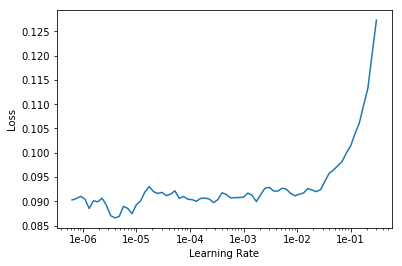

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(6, 2e-3)

Total time: 1:28:31
epoch  train_loss  valid_loss  fbeta   
1      0.090676    0.086750    0.683142  (14:51)
2      0.097232    0.087681    0.678104  (14:44)
3      0.091124    0.085446    0.702445  (14:45)
4      0.090842    0.081596    0.712639  (14:44)
5      0.085370    0.078515    0.722344  (14:43)
6      0.083320    0.078654    0.724383  (14:42)



In [ ]:
learn.unfreeze()
learn.fit_one_cycle(14, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,fbeta
1,0.083767,0.078253,0.729399
2,0.085826,0.079158,0.721641
3,0.082678,0.080231,0.713281
4,0.085863,0.077682,0.725548
5,0.082020,0.083065,0.715122
6,0.081494,0.077964,0.723569
7,0.080943,0.076673,0.728584
8,0.082724,0.076933,0.730056
9,0.079051,0.075102,0.733879
10,0.076876,0.075441,0.732775


In [ ]:
learn.save("stratified-model-5-512-unfreeze")

In [ ]:
_ = learn.load("stratified-model-5-512-unfreeze")

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(14, slice(1e-8, 5e-6))

In [ ]:
learn.save("stratified-model-5-512-unfreeze")